In [205]:
from omero.gateway import BlitzGateway
from data_preperation import *

In [206]:
import logging

import numpy as np
from omero.gateway import BlitzGateway, DatasetWrapper, ImageWrapper, ProjectWrapper, FileAnnotationWrapper
import microscopemetrics_schema.datamodel as mm_schema
from linkml_runtime.loaders import yaml_loader

from omero_metrics.tools import omero_tools




In [207]:
conn = BlitzGateway("Asterix", "abc123",group='IGH-Z3', host="localhost", port=6064, secure=True)
conn.connect()

True

In [ ]:
user = conn.getUser()
print("Current user:")
print("   ID:", user.getId())
print("   Username:", user.getName())
print("   Full Name:", user.getFullName())

# Check if you are an Administrator
print("   Is Admin:", conn.isAdmin())
if not conn.isFullAdmin():
    # If 'Restricted Administrator' show privileges
    print(conn.getCurrentAdminPrivileges())

print("Member of:")
for g in conn.getGroupsMemberOf():
    print("   ID:", g.getName(), " Name:", g.getId())
group = conn.getGroupFromContext()
print("Current group: ", group.getName())

# List the group owners and other members
owners, members = group.groupSummary()
print("   Group owners:")
for o in owners:
    print("     ID: %s %s Name: %s" % (
        o.getId(), o.getOmeName(), o.getFullName()))
print("   Group members:")
for m in members:
    print("     ID: %s %s Name: %s" % (
        m.getId(), m.getOmeName(), m.getFullName()))

print("Owner of:")
for g in conn.listOwnedGroups():
    print("   ID: ", g.getName(), " Name:", g.getId())

# Added in OMERO 5.0
print("Admins:")
for exp in conn.getAdministrators():
    print("   ID: %s %s Name: %s" % (
        exp.getId(), exp.getOmeName(), exp.getFullName()))

# The 'context' of our current session
ctx = conn.getEventContext()
# print(ctx)     # for more info

In [ ]:
for group in conn.listOwnedGroups():
    owners, members = group.groupSummary()
    print("   Group owners:")
    for o in owners:
        print("     ID: %s %s Name: %s" % (
            o.getId(), o.getOmeName(), o.getFullName()))
    print("   Group members:")
    for m in members:
        print("     ID: %s %s Name: %s" % (
            m.getId(), m.getOmeName(), m.getFullName()))

In [ ]:
roi_ids = [r.getId().getValue() for r in result.rois]

In [ ]:
image = conn.getObject("Image", 1)

In [ ]:
image

In [ ]:
dataset = image.getParent()

In [ ]:
analysis_type = get_analysis_type(image.getParent().getParent())

In [ ]:
analysis_type

In [ ]:
roi_service = conn.getRoiService()
result = roi_service.findByImage(int(3), None, conn.SERVICE_OPTS)
shapes_rectangle, shapes_line = get_rois_omero(result)
df_lines_omero = get_info_roi_lines(shapes_line)

In [ ]:
for i in conn.listOwnedGroups():
    print(f'------------------------------{i.getName()}----------------------------------')
    conn.SERVICE_OPTS.setOmeroGroup(i.getId())
    for project in conn.getObjects("Project"):
        print(project.getName(), project.getId())

In [ ]:

shapes_line = {}
shapes_rectangle = {}
for roi in result.rois:
    for s in roi.copyShapes():
        shape = {}
        shape["id"] = s.getId().getValue()
        if s.getTextValue():
            shape["textValue"] = s.getTextValue().getValue()
        if s.__class__.__name__ == "RectangleI":
            shape["type"] = "Rectangle"
            shape["x"] = s.getX().getValue()
            shape["y"] = s.getY().getValue()
            shape["w"] = s.getWidth().getValue()
            shape["h"] = s.getHeight().getValue()
            shapes_rectangle[s.getId().getValue()] = shape
        elif s.__class__.__name__ == "LineI":
            shape["type"] = "Line"
            shape["x1"] = s.getX1().getValue()
            shape["x2"] = s.getX2().getValue()
            shape["y1"] = s.getY1().getValue()
            shape["y2"] = s.getY2().getValue()
            shapes_line[s.getId().getValue()] = shape
        elif s.__class__.__name__ == "PolygonI":
            continue


In [ ]:
g = conn.listProjects()

In [ ]:
for project in conn.getObjects("Project", opts={'group': 4}):
    print(project.getName(), project.getId())

In [ ]:
def get_data_ids(conn):
    for i in conn.listOwnedGroups():
        conn.SERVICE_OPTS.setOmeroGroup(i.getId())
        for project in conn.getObjects("Project"):
            print(project.getName(), project.getId())

In [ ]:
conn.SERVICE_OPTS.setOmeroGroup(-1)
for image in conn.getObjects("Image"):
    print(image.getName(), image.getId())

In [ ]:
dataset_4 = conn.getObject("Dataset", 52)
dataset_6 = conn.getObject("Dataset", 6)


In [ ]:
dataset_4.getAnnotation()

In [ ]:
dataset_4.getAnnotationCounts()

In [ ]:
an= conn.getObject("MapAnnotation", 6)


In [ ]:
ann = dataset_4.getAnnotation()
print("Found Annotation with namespace: ", ann.getNs())

In [ ]:
ann = dataset_4.getAnnotation()
print("Found Annotation with namespace: ", ann.getNs())

In [ ]:
def get_dataset_ids_lists(conn, project_id):
    """
    Get the processed and unprocessed dataset ids for a project
    """
    processed_datasets = []
    unprocessed_datasets = []
    project = conn.getObject("Project", project_id)
    for dataset in project.listChildren():
        try:
            dataset.getAnnotation().getNs()
            processed_datasets.append(dataset.getId())
        except AttributeError:
            unprocessed_datasets.append(dataset.getId())
    return processed_datasets, unprocessed_datasets

In [ ]:
l, n = get_dataset_ids_lists(conn, 3)

In [ ]:
cxt = {'processed_datasets': l, 'unprocessed_datasets': n}

In [ ]:
cxt["processed_datasets"]

In [ ]:
def get_map_annotation(dataset_wrapper, conn):
    df = None
    for i in dataset_wrapper.listAnnotations():
        if i.__class__.__name__ == "MapAnnotationWrapper":
            keyPairs = conn.getObject("MapAnnotation", i.getId())
            table = dict(keyPairs.getValue())
            df = pd.DataFrame(table.items(), columns=["Key", "Value"])
    return df


In [ ]:
def get_dataset_mapAnnotation(conn, dataset_id):
    """
    Get the mapAnnotation for a dataset
    """
    dataset = conn.getObject("Dataset", dataset_id)
    try:
        for i in dataset.listAnnotations():
            if "FieldIlluminationKeyValues" in i.getNs():
                table = dict(i.getValue())
                df = pd.DataFrame(table.items(), columns=["Key", "Value"])
                break
        return df
    except:
        return None

In [ ]:
get_dataset_mapAnnotation(conn, 52)

In [ ]:
for i in dataset_4.listAnnotations():
    print(i.getNs.getValue())

In [ ]:
import pandas as pd

In [ ]:
a = np.arange(12).reshape(3, 4)
np.fliplr(a).diagonal()  # Horizontal flip


In [ ]:
import numpy as np

In [ ]:
np.fliprl(a).diagonal()  # Vertical flip


In [ ]:
b = np.flip(a, axis=1)
print(b[:,-1])
print(b[:,0])
print(np.fliplr(b).diagonal())
print(np.fliplr(a).diagonal())

In [ ]:
np.fliplr(b).diagonal()

In [ ]:
b[:,-1]

In [ ]:
b

In [ ]:
from .load import *

In [ ]:
df_X

In [ ]:
def get_table_originalFile_id(conn,file_id):
    ctx = conn.createServiceOptsDict()
    ctx.setOmeroGroup("-1")
    r = conn.getSharedResources()
    t = r.openTable(omero.model.OriginalFileI(file_id), ctx)   
    data_buffer = collections.defaultdict(list)
    heads = t.getHeaders()
    target_cols = range(len(heads))
    index_buffer = []
    num_rows = t.getNumberOfRows()
    for start in range(0, num_rows):
        data = t.read(target_cols, start, start)
        for col in data.columns:
            data_buffer[col.name] += col.values
        index_buffer += data.rowNumbers
    df = pd.DataFrame.from_dict(data_buffer)
    df.index = index_buffer[0: len(df)]
    return df

In [ ]:
df_X = get_table_originalFile_id(conn,121)
df_Y = get_table_originalFile_id(conn,120)
df_Z = get_table_originalFile_id(conn,119)
df_P = get_table_originalFile_id(conn,118)

In [ ]:
df_P

In [ ]:
df_meta = pd.DataFrame(data=[[int(col.split("_")[-2]), int(col.split("_")[-4]), col.split("_")[-1], col] for col in df_X.columns], columns=['bead_nb', 'channel_nb', 'type', 'name'])

In [ ]:
for col in df_X.columns:
    s = df_X[col]

In [ ]:
df = df_X.copy()

In [ ]:
df_meta

In [ ]:
b ='PSF-beads_60x_2021-03-01_ch_00_bead_00_raw'.split('_')

In [ ]:
df_X

In [ ]:

def get_rois_omero(result):
    shapes_line = {}
    shapes_rectangle = {}
    shapes_point = {}
    for roi in result.rois:
        for s in roi.copyShapes():
            shape = {}
            shape["id"] = s.getId().getValue()
           # shape["theT"] = s.getTheT().getValue()
           # shape["theZ"] = s.getTheZ().getValue()
            if s.getTextValue():
                shape["textValue"] = s.getTextValue().getValue()
            if s.__class__.__name__ == "RectangleI":
                shape["type"] = "Rectangle"
                shape["x"] = s.getX().getValue()
                shape["y"] = s.getY().getValue()
                shape["w"] = s.getWidth().getValue()
                shape["h"] = s.getHeight().getValue()
                shapes_rectangle[s.getId().getValue()] = shape
            elif s.__class__.__name__ == "LineI":
                shape["type"] = "Line"
                shape["x1"] = s.getX1().getValue()
                shape["x2"] = s.getX2().getValue()
                shape["y1"] = s.getY1().getValue()
                shape["y2"] = s.getY2().getValue()
                
                shapes_line[s.getId().getValue()] = shape
            elif s.__class__.__name__ == "PointI":
                shape['type'] = 'Point'
                shape['x'] = s.getX().getValue()
                shape['y'] = s.getY().getValue()
                shape['z'] = s.getTheZ().getValue()
                shape['channel'] = s.getTheC().getValue()
                shapes_point[s.getId().getValue()] = shape
            elif s.__class__.__name__ == "PolygonI":
                continue
    return shapes_rectangle, shapes_line, shapes_point



In [ ]:
get_rois_omero()

In [ ]:
roi_service = conn.getRoiService()
result = roi_service.findByImage(int(20), None, conn.SERVICE_OPTS)
shapes_rectangle, shapes_line, shapes_point = get_rois_omero(result)
df_points_omero = get_info_roi_points(shapes_point)

In [ ]:
df_points_omero.groupby('Z').count().idxmax().ROI

In [ ]:
df_g

In [ ]:
df_points_omero

In [ ]:
def get_info_roi_points(shape_dict):
    data = [
        [key, int(value["x"]), int(value["y"]),int(value["z"]), int(value["channel"]) ]
        for key, value in shape_dict.items()
    ]
    df = pd.DataFrame(data, columns=["ROI", "X", "Y", "Z", 'C'])
    return df

In [ ]:
dataset3 = conn.getObject("Dataset", 3).getParent().getId()
dataset3

In [ ]:
coll = load_project(conn, 1)

In [ ]:
from load import load_project

In [ ]:
for i in coll['datasets']:
    #i['processed']
    #i['data_reference']["omero_object_id"]
    #i['data_reference']["omero_object_type"]
    #i['input]["field_illumination_image"]['data_reference']["omero_object_id"]
    print(i['output']['intensity_profiles'][0]['data_reference']["omero_object_id"])
    print(i['output']['key_values'])

In [ ]:
data_reference:
  data_uri: https://localhost:6064/webclient/?show=image-69
  omero_host: localhost
  omero_port: 6064
  omero_object_type: IMAGE
  omero_object_id: 69

In [ ]:
print(f"conn.getGroupFromContext(): {conn.getGroupFromContext().getId()}")
print(f"conn.SERVICE_OPTS.getOmeroGroup(): {conn.SERVICE_OPTS.getOmeroGroup()}")
 

In [ ]:
import microscopemetrics_schema.datamodel as mm_schema



In [ ]:
for i in conn.listGroups():
    print(i.getId())

In [ ]:
def get_project_data(collections: mm_schema.MetricsDatasetCollection) -> pd.DataFrame:
    data = []
    for dataset in collections.datasets:
        data.append([dataset.__class__.__name__, dataset.data_reference.omero_object_type, dataset.data_reference.omero_object_id, dataset.processed, dataset.acquisition_datetime])
    df = pd.DataFrame(data, columns=["Analysis_type", "Omero_object_type", "Omero_object_id", "Processed", "Acquisition_datetime"])
    return df

In [ ]:
df = get_project_data(coll)
df['Omero_object_type'][0]

In [ ]:
for i in coll.datasets:
    print(type(i.data_reference.omero_object_type))

In [ ]:
def get_dataset_data(collections: mm_schema.MetricsDatasetCollection, dataset_id) -> mm_schema.MetricsDataset:
    try:
        dataset = [i for i in collections.datasets if i.data_reference.omero_object_id == dataset_id][0]
        return dataset
    except:
        return None


In [ ]:
b = get_dataset_data(coll, 59)

In [ ]:
b.processed

In [ ]:
def get_dataset_data_dash(dataset: mm_schema.MetricsDataset) -> pd.DataFrame:
    if dataset.processed:
        

In [ ]:
def get_images_intensity_profilers(dataset: mm_schema.MetricsDataset) -> pd.DataFrame:
    data=[]
    for i,j in zip(dataset.input['field_illumination_image'],dataset.output["intensity_profiles"]):
        data.append([i['data_reference']['omero_object_id'], j['data_reference']['omero_object_id'], i['shape_c']])
    df = pd.DataFrame(data, columns=["Field_illumination_image", "Intensity_profiles", "Channel"])
    return df

In [ ]:
for i in b.output["intensity_profiles"]:
    print()

In [ ]:
b1 = get_images_intensity_profilers(b)

In [ ]:
image_77 = conn.getObject("Image", 77)
image_76 = conn.getObject("Image", 76)
image_75 = conn.getObject("Image", 75)

In [ ]:
from load import load_image

In [ ]:
image_77_na = load_image(image_77)
image_76_na = load_image(image_76)
image_75_na = load_image(image_75)


In [ ]:
image_77_na.shape

In [ ]:
np.insert(image_77_na, image_76_na, axis=4)

In [ ]:
import numpy as np

# Assuming array1 has shape (1, 1, 512, 812, 2) and array2 has shape (1, 1, 512, 812, 1)
array2_padded = np.pad(image_75_na, ((0, 0), (0, 0), (0, 0), (0, 0), (0, 1)), 'constant')


# Now array2_padded has shape (1, 1, 512, 812, 2), and you can add the two arrays together
result = image_77_na + array2_padded

In [ ]:
result.shape

In [ ]:
def test(conn, df):
    image_0 = conn.getObject('Image',df['Field_illumination_image'][0])
    image_array_0 = load_image(image_0)
    result = image_array_0
    for i in range(1, len(df)):
        image = conn.getObject('Image', df['Field_illumination_image'][i])
        image_array = load_image(image)
        result = np.concatenate((result,image_array), axis=-1)
    return result
    

In [ ]:
images = test(conn, b1 )

In [ ]:
images.shape

In [ ]:
result = np.concatenate((image_77_na, image_76_na), axis=-1)


In [ ]:
images.shape

In [ ]:
def get_intensity_profilers(conn, df):
    
        
    

NameError: name 'get_images_intensity_profilers' is not defined

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'Table'

In [ ]:
conn.getObject('FileAnnotation', 131).getFile().getId()

In [ ]:
b1

In [ ]:
df

In [ ]:
project_id = conn.getObject("Dataset", 1).getParent().getId()

In [ ]:
project_id

In [ ]:
from load import get_dataset_by_id, get_key_value

In [ ]:
coll = load_project(conn, 1)

In [ ]:
dataset = get_dataset_by_id(coll, 1)

In [7]:
import load

In [68]:
project_id = conn.getObject("Dataset", 3).getParent().getId()
collections_mm_p = load.load_project(conn, project_id)
#dataset = load.get_dataset_by_id(collections_mm_p, dataset_id)
dataset = [i for i in collections_mm_p.datasets if i.data_reference.omero_object_id == 3][0]
dataset

FieldIlluminationDataset(name='FI_10x_2021-03-04', description='Field Illumination dataset', data_reference=DataReference(data_uri='https://localhost:6064/webclient/?show=dataset-3', omero_host='localhost', omero_port=6064, omero_object_type=(text='DATASET', description='A dataset'), omero_object_id=3), linked_references=[], microscope=Microscope(name='IGH-Z3', description=None, data_reference=None, linked_references=[], type=None, manufacturer=None, model=None, serial_number=None, comments={}), input=FieldIlluminationInput(field_illumination_image=[Image(name='FI_10x_DAPI_2021-03-04', description='An image taken on the IGH-Z3 microscope on the 2021-03-04 for QC', data_reference=DataReference(data_uri='https://localhost:6064/webclient/?show=image-7', omero_host='localhost', omero_port=6064, omero_object_type=(text='IMAGE', description='An image'), omero_object_id=7), linked_references=[], shape_x=812, shape_y=512, acquisition_datetime='2024-05-06T15:27:25.393091', shape_z=1, shape_c=1,

In [ ]:
for i in collections_mm_p.datasets:
    print(i.data_reference.omero_object_id)

In [ ]:
if dataset.processed:
    print('processed')
else:
    print('unprocessed')

In [ ]:
from load import *

In [71]:
var = dataset.output

In [91]:
channel_list

[{'label': 'DAPI', 'value': 'channel 0'},
 {'label': 'FITC', 'value': 'channel 1'},
 {'label': 'TRITC', 'value': 'channel 2'},
 {'label': 'CY5', 'value': 'channel 3'}]

In [88]:
channel_list = [{'label': labels[i], 'value': f"channel {i}"} for i in range(len(labels))]

In [87]:
labels = df2.columns[:-1].to_list()

In [12]:
df = load.get_key_values(dataset.output)

In [27]:
df = pd.DataFrame(columns=dataset.output.key_values.channel_name)
df


,DAPI,FITC,TRITC,CY5


In [19]:
for k, v in dataset.output.key_values.__dict__.items():
    if k in ['name', 'description', 'data_reference', 'linked_references', 'channel_name']:
        pass
    else:


name
description
data_reference
linked_references
channel_name
center_region_intensity_fraction
center_region_area_fraction
center_of_mass_y
center_of_mass_y_relative
center_of_mass_x
center_of_mass_x_relative
center_of_mass_distance_relative
center_geometric_y
center_geometric_y_relative
center_geometric_x
center_geometric_x_relative
center_geometric_distance_relative
center_fitted_y
center_fitted_y_relative
center_fitted_x
center_fitted_x_relative
center_fitted_distance_relative
max_intensity
max_intensity_pos_y
max_intensity_pos_y_relative
max_intensity_pos_x
max_intensity_pos_x_relative
max_intensity_distance_relative
top_left_intensity_mean
top_left_intensity_ratio
top_center_intensity_mean
top_center_intensity_ratio
top_right_intensity_mean
top_right_intensity_ratio
middle_left_intensity_mean
middle_left_intensity_ratio
middle_center_intensity_mean
middle_center_intensity_ratio
middle_right_intensity_mean
middle_right_intensity_ratio
bottom_left_intensity_mean
bottom_left_intensi

In [92]:
dataset

FieldIlluminationDataset(name='FI_10x_2021-03-04', description='Field Illumination dataset', data_reference=DataReference(data_uri='https://localhost:6064/webclient/?show=dataset-3', omero_host='localhost', omero_port=6064, omero_object_type=(text='DATASET', description='A dataset'), omero_object_id=3), linked_references=[], microscope=Microscope(name='IGH-Z3', description=None, data_reference=None, linked_references=[], type=None, manufacturer=None, model=None, serial_number=None, comments={}), input=FieldIlluminationInput(field_illumination_image=[Image(name='FI_10x_DAPI_2021-03-04', description='An image taken on the IGH-Z3 microscope on the 2021-03-04 for QC', data_reference=DataReference(data_uri='https://localhost:6064/webclient/?show=image-7', omero_host='localhost', omero_port=6064, omero_object_type=(text='IMAGE', description='An image'), omero_object_id=7), linked_references=[], shape_x=812, shape_y=512, acquisition_datetime='2024-05-06T15:27:25.393091', shape_z=1, shape_c=1,

In [134]:
def get_all_intensity_profiles(conn, dataset):
    data_df = load.get_images_intensity_profilers(dataset)
    df_01 = pd.DataFrame()
    for i, row in data_df.iterrows():
        file_id = conn.getObject('FileAnnotation', row.Intensity_profiles).getFile().getId()
        data = get_table_originalFile_id(conn,str(file_id))
        for j in range( row.Channel):
                regx_find = f'ch0{j}'
                ch = i+j
                regx_repl = f'Ch0{ch}'
                data.columns = data.columns.str.replace(regx_find, regx_repl)
        df_01 = pd.concat([df_01, data], axis=1)
    return df_01
    


,Ch00_leftTop_to_rightBottom,Ch00_leftBottom_to_rightTop,Ch00_center_horizontal,Ch00_center_vertical,Ch01_leftTop_to_rightBottom,Ch01_leftBottom_to_rightTop,Ch01_center_horizontal,Ch01_center_vertical,Ch02_leftTop_to_rightBottom,Ch03_leftTop_to_rightBottom,Ch02_leftBottom_to_rightTop,Ch03_leftBottom_to_rightTop,Ch02_center_horizontal,Ch03_center_horizontal,Ch02_center_vertical,Ch03_center_vertical
0,30145.0,38301.0,34904.0,29467.0,23384.0,35071.0,31731.0,26768.0,29115.0,22129.0,34559.0,34526.0,36939.0,33268.0,32024.0,23804.0
1,30100.0,38269.0,34917.0,29294.0,23512.0,35017.0,31898.0,26810.0,29463.0,22272.0,34752.0,34515.0,37234.0,33956.0,32031.0,24011.0
2,30027.0,38290.0,34870.0,29520.0,23839.0,35237.0,31889.0,26859.0,29546.0,22407.0,35003.0,34404.0,37264.0,33604.0,32289.0,23967.0
3,30273.0,38294.0,35062.0,29631.0,23879.0,35339.0,32078.0,27102.0,29667.0,22818.0,35167.0,34763.0,37296.0,33869.0,32392.0,24257.0
4,30265.0,38398.0,35104.0,29661.0,23921.0,35425.0,32274.0,27188.0,29996.0,22967.0,35287.0,35160.0,37661.0,34035.0,32501.0,24224.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.0,0.0,0.0,37126.0,0.0,0.0,0.0,40352.0,0.0,0.0,0.0,0.0,0.0,0.0,37876.0,36850.0
251,0.0,0.0,0.0,37142.0,0.0,0.0,0.0,40288.0,0.0,0.0,0.0,0.0,0.0,0.0,37769.0,36870.0
252,0.0,0.0,0.0,37127.0,0.0,0.0,0.0,40416.0,0.0,0.0,0.0,0.0,0.0,0.0,37635.0,36701.0
253,0.0,0.0,0.0,37236.0,0.0,0.0,0.0,40235.0,0.0,0.0,0.0,0.0,0.0,0.0,37870.0,36965.0


In [131]:
data.columns.str.replace('ch00', 'X', regex=True)

Index(['X_leftTop_to_rightBottom', 'ch01_leftTop_to_rightBottom',
       'X_leftBottom_to_rightTop', 'ch01_leftBottom_to_rightTop',
       'X_center_horizontal', 'ch01_center_horizontal', 'X_center_vertical',
       'ch01_center_vertical'],
      dtype='object')

In [127]:
data.columns 

Index(['ch00_leftTop_to_rightBottom', 'ch01_leftTop_to_rightBottom',
       'ch00_leftBottom_to_rightTop', 'ch01_leftBottom_to_rightTop',
       'ch00_center_horizontal', 'ch01_center_horizontal',
       'ch00_center_vertical', 'ch01_center_vertical'],
      dtype='object')

In [115]:
regx_find = f'ch_0{0}'
regx_find

'ch_00'

In [106]:
b1

,Field_illumination_image,Intensity_profiles,Channel
0,7,19,1
1,8,20,1
2,9,21,2


In [150]:
imo = conn.getObject("Image", 19)

In [149]:
type(imo)

NoneType

In [146]:
import load

In [151]:
ima = load.load_image(imo)

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io



In [216]:
IM_MAX

(61, 40)

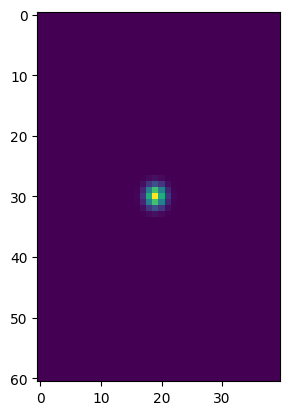

In [181]:
ima1 = ima[0,:, 159:199,229:269,0]
IM_MAX= np.max(ima1, axis=2)
plt.imshow(IM_MAX)

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure


# Create the maximum intensity projection along the z-axis (axis=0)
mip = measure.maximum_intensity_projection(ima1, axis=0)

# Display the original stack and the maximum intensity projection
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(ima1.max(axis=0), cmap='gray')
axes[0].set_title('Original Stack MIP')
axes[1].imshow(mip, cmap='gray')
axes[1].set_title('Maximum Intensity Projection')
plt.show()

AttributeError: module 'skimage.measure' has no attribute 'maximum_intensity_projection'

In [171]:
stack = ima1

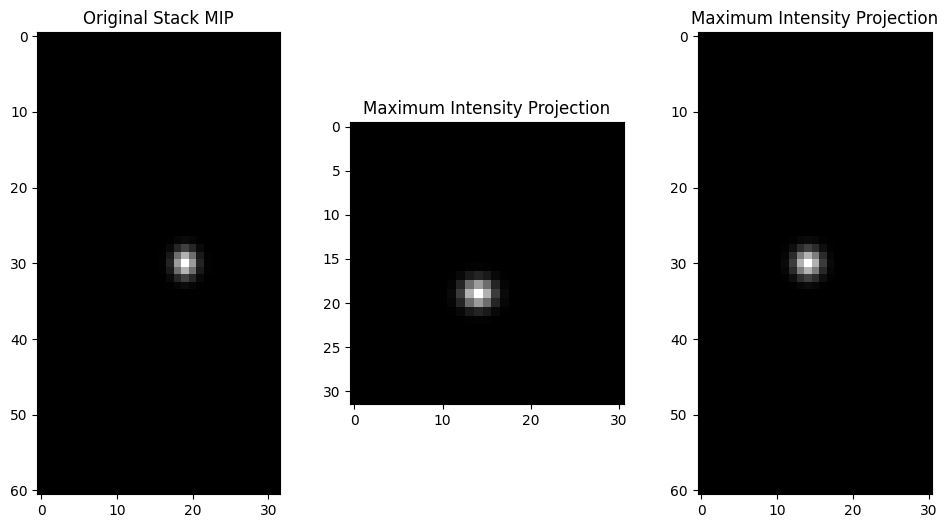

In [176]:
# Create the maximum intensity projection along the z-axis (axis=0)
mip = np.max(stack, axis=0)
TZYXC
# Display the original stack and the maximum intensity projection
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(stack.max(axis=2), cmap='gray')
axes[0].set_title('Original Stack MIP')
axes[1].imshow(mip, cmap='gray')
axes[1].set_title('Maximum Intensity Projection')
axes[2].imshow(stack.max(axis=1), cmap='gray')
axes[2].set_title('Maximum Intensity Projection')
plt.show()

In [185]:
from load import *

In [188]:
project = load_project(conn, 3)

In [189]:
dataset =  get_dataset_by_id(project, 7)

In [193]:
var = dataset.output

In [210]:
len(var.key_values.channel_nr)

4

In [195]:
data_dict = var.key_values.__dict__
data_dict = [value + [key] for key, value in data_dict.items() if
             isinstance(value, list) and key not in ['name', 'description', 'data_reference', 'linked_references',
                                                     'channel_name']]
df = pd.DataFrame(data_dict, columns=var.key_values.channel_nr + ['Parameter'])
df


,0,1,2,3,Parameter
0,0,1.000000,2.000000,3.000000,channel_nr
1,11,11.000000,11.000000,11.000000,nr_of_beads_analyzed
2,2,2.000000,2.000000,2.000000,nr_of_beads_discarded_lateral_edge
3,2,2.000000,2.000000,2.000000,nr_of_beads_discarded_self_proximity
4,2,2.000000,2.000000,2.000000,nr_of_beads_considered_axial_edge
5,0,0.000000,0.000000,0.000000,nr_of_beads_considered_intensity_outlier
6,0,0.000000,0.000000,0.000000,nr_of_beads_considered_bad_z_fit
7,0,0.000000,0.000000,0.000000,nr_of_beads_considered_bad_y_fit
8,0,0.000000,0.000000,0.000000,nr_of_beads_considered_bad_x_fit
9,0.993045,0.997233,0.994279,0.983382,fit_r2_z_mean


In [202]:
bead_properties_id = dataset.output.bead_properties.data_reference.omero_object_id
bead_x_profiles_id = dataset.output.bead_x_profiles.data_reference.omero_object_id
bead_y_profiles_id = dataset.output.bead_y_profiles.data_reference.omero_object_id
bead_z_profiles_id = dataset.output.bead_z_profiles.data_reference.omero_object_id


In [208]:
bead_properties_df = get_table_File_id(conn, dataset.output.bead_properties.data_reference.omero_object_id)
bead_x_profiles_df = get_table_File_id(conn, dataset.output.bead_x_profiles.data_reference.omero_object_id)
bead_y_profiles_df = get_table_File_id(conn, dataset.output.bead_y_profiles.data_reference.omero_object_id)
bead_z_profiles_df = get_table_File_id(conn, dataset.output.bead_z_profiles.data_reference.omero_object_id)

In [209]:
 bead_properties_df

,image_name,channel_nr,bead_nr,intensity_max,min_intensity_min,intensity_std,intensity_robust_z_score,considered_intensity_outlier,z_centroid,y_centroid,...,y_fit_r2,x_fit_r2,considered_bad_z_fit,considered_bad_y_fit,considered_bad_x_fit,z_fwhm,y_fwhm,x_fwhm,fwhm_lateral_asymmetry_ratio,considered_axial_edge
0,PSF-beads_60x_2021-02-01,0,0,53395,23908,505.324540,0.740696,0,30,178,...,0.954354,0.989149,0,0,0,3.232681,3.232684,3.232687,1.000001,0
1,PSF-beads_60x_2021-02-01,0,1,52912,23908,497.598158,0.695345,0,30,29,...,0.954432,0.989080,0,0,0,3.232681,3.232684,3.232684,1.000000,0
2,PSF-beads_60x_2021-02-01,0,2,52327,23908,487.643943,0.640416,0,57,297,...,0.954315,0.989077,0,0,0,3.232680,3.232684,3.232684,1.000000,1
3,PSF-beads_60x_2021-02-01,0,3,53200,23908,501.539389,0.722387,0,57,134,...,0.954140,0.988995,0,0,0,3.232680,3.232684,3.232684,1.000000,1
4,PSF-beads_60x_2021-02-01,0,4,53588,23908,509.272704,0.758818,0,30,312,...,0.954428,0.989228,0,0,0,3.232681,3.232684,3.232684,1.000000,0
5,PSF-beads_60x_2021-02-01,0,5,53859,23908,511.722231,0.784264,0,30,107,...,0.953598,0.988798,0,0,0,3.232681,3.232684,3.232684,1.000000,0
6,PSF-beads_60x_2021-02-01,0,6,53755,23908,511.563098,0.774499,0,30,389,...,0.954257,0.989123,0,0,0,3.232680,3.232684,3.232684,1.000000,0
7,PSF-beads_60x_2021-02-01,0,7,53584,23908,508.167084,0.758443,0,30,470,...,0.954119,0.988977,0,0,0,3.232681,3.232684,3.232684,1.000000,0
8,PSF-beads_60x_2021-02-01,0,8,57001,23908,1109.025299,1.079285,0,30,168,...,0.977955,0.991848,0,0,0,3.232681,3.266033,3.301446,1.010843,0
9,PSF-beads_60x_2021-02-01,0,9,53206,23908,500.116947,0.722950,0,30,184,...,0.953689,0.988621,0,0,0,3.232681,3.232684,3.232684,1.000000,0


In [214]:
for i in dataset.input.psf_beads_images:
    print(i.data_reference.omero_object_id)

19


In [215]:
dataset.input.psf_beads_images[0].data_reference.omero_object_id

19